# Experiments

In [1]:
from itertools import product
from time import time
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import os
import joblib
import numpy as np

from lib.models import MLP
from lib.EarlyStopping import EarlyStopping
from lib.regularization_functions import Lasso, Ridge
from lib.metrics import MSE
from lib.GridSearch import GridSearch
from lib.optimizers import HBG, CFM
from lib.utils import compute_best_loss_k
from data.load_data import load_ML_CUP21

plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
X, y = load_ML_CUP21()
print("Input features shape: ", X.shape)
print("Targets shape: ", y.shape)

Input features shape:  (1477, 10)
Targets shape:  (1477, 2)


## Experiment 0.1 - Threshold Influence in CFM

In [3]:
n_experiment = "0.1"
experiment_folder = f"results/{n_experiment}"
if not os.path.exists(experiment_folder):
    os.mkdir(experiment_folder)

experiment_parameters = {"architecture": [10, 30, 2], "activation": "relu", "l1": 1e-1}
model = MLP(experiment_parameters["architecture"], activation = experiment_parameters["activation"])
model.compile(error_function = MSE(), regularization_function = Lasso(l1 = experiment_parameters["l1"]))

In [4]:
a_values = [50, 75, 100, 150, 200]
gamma = 0.5

In [ ]:
for a in a_values:
    opt = CFM(delta_k = f"{a}/({a} + k)", gamma = gamma)
    early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
    model.fit(X, y, optimizer = opt, early_stopping = early_stopping, epochs = 10000)
    joblib.dump(model, f"{experiment_folder}/a={a}_model")

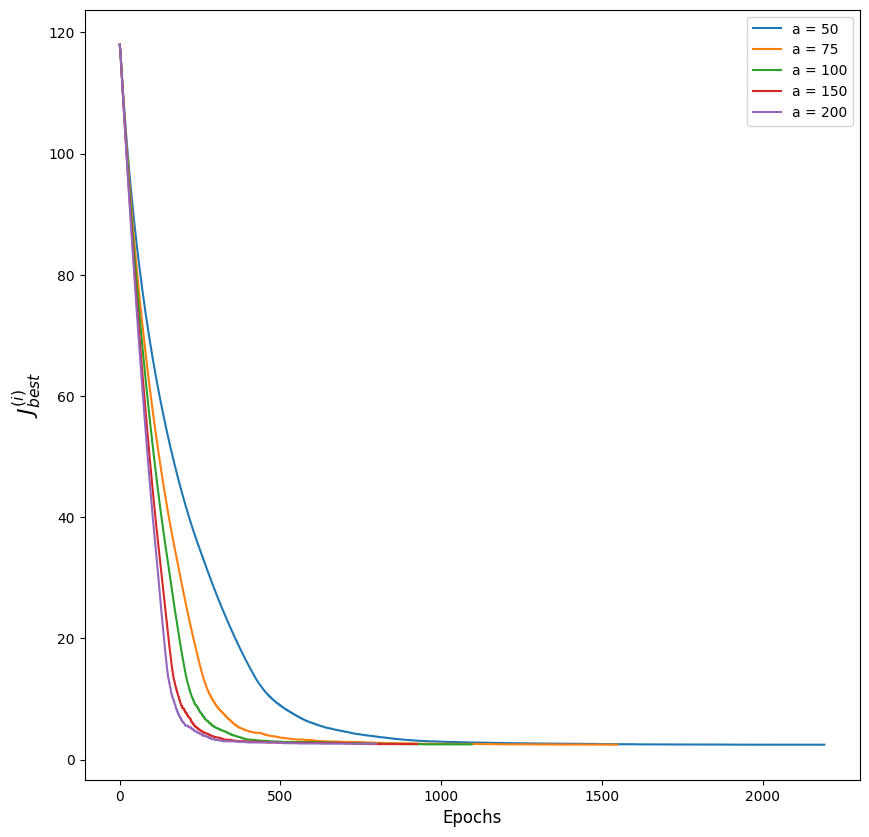

In [5]:
for a in a_values:
    loss = joblib.load(f"{experiment_folder}/a={a}_model")._eval["train_loss"]
    plt.plot(compute_best_loss_k(loss), label = f"a = {a}")
plt.ylabel("$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.legend()
plt.show()

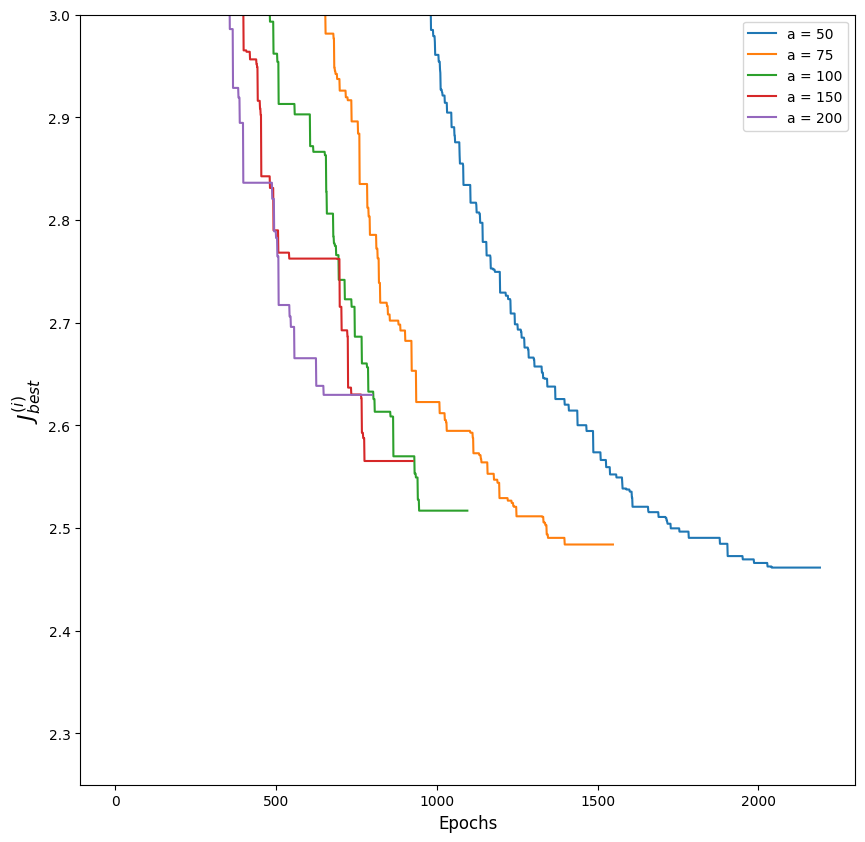

In [6]:
for a in a_values:
    loss = joblib.load(f"{experiment_folder}/a={a}_model")._eval["train_loss"]
    plt.plot(compute_best_loss_k(loss), label = f"a = {a}")
plt.ylim((2.25, 3))
plt.ylabel("$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.legend()
plt.show()

## Experiment 0.2 - Convex Loss Function

In [7]:
n_experiment = "0.2"
experiment_folder = f"results/{n_experiment}"
if not os.path.exists(experiment_folder):
    os.mkdir(experiment_folder)

In [8]:
experiment_parameters = {"architecture": [10, 60, 2], "activation": "identity", "l1": 1e-1}
model = MLP(experiment_parameters["architecture"], activation = experiment_parameters["activation"])
model.compile(error_function = MSE(), regularization_function = Lasso(l1 = experiment_parameters["l1"]))

### HBG

#### Grid Search

In [ ]:
alpha_values = [5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.75e-3, 1e-2, 2.5e-2, 5e-2]
beta_values = [0.1, 0.25, 0.5, 0.75, 0.9]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [HBG(alpha = a, beta = b) for a, b in product(alpha_values, beta_values)],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid)

joblib.dump(grid_search, f"{experiment_folder}/HBG_grid_search")

In [9]:
best_params_combinations = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: HBG Optimizer(alpha = 0.00075, beta = 0.9)
-> Score: 2.188
Params combination N. 1
-> Optimizer: HBG Optimizer(alpha = 0.0005, beta = 0.9)
-> Score: 2.188
Params combination N. 2
-> Optimizer: HBG Optimizer(alpha = 0.001, beta = 0.9)
-> Score: 2.189


#### Timing

In [15]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
timings = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    timings.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(timings) * 1e3, 3)}ms +- {round(np.std(timings) * 1e3, 3)}ms")

Time per epoch: 2.719ms +- 0.068ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 10
train_losses = []
for run in range(1, n_random_runs + 1):
    opt = best_params["optimizer"]
    model.fit(X, y, optimizer = opt, epochs = 100000, random_seed = run, verbose = False)
    fitting_times.append(end_time - start_time)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/HBG_random_runs")

In [11]:
train_losses = joblib.load(f"{experiment_folder}/HBG_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 2.182 +- 0.0


### CFM with Target Level

#### Grid Search

In [ ]:
gamma_values = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1, 1.25, 1.5]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [CFM(gamma = g, delta_k = "150/(150 + k)") for g in gamma_values],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid)

joblib.dump(grid_search, f"{experiment_folder}/CFM-TL_grid_search")

In [12]:
best_params_combinations = joblib.load(f"{experiment_folder}/CFM-TL_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 150/(150 + k), gamma = 0.2)
-> Score: 2.238
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 150/(150 + k), gamma = 0.1)
-> Score: 2.251
Params combination N. 2
-> Optimizer: CFM Optimizer(delta_k = 150/(150 + k), gamma = 0.15)
-> Score: 2.27


#### Timing

In [16]:
best_params = joblib.load(f"{experiment_folder}/CFM-TL_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 2.845ms +- 0.022ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/CFM-TL_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 10
train_losses = []
for run in range(1, n_random_runs + 1):
    opt = best_params["optimizer"]
    model.fit(X, y, optimizer = opt, epochs = 100000, random_seed = run, verbose = False)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/CFM-TL_random_runs")

In [13]:
train_losses = joblib.load(f"{experiment_folder}/HBG_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 2.182 +- 0.0


### CFM with Known Best Loss

In [14]:
best_loss = 2.18
opt = CFM(gamma = 0.2, best_loss = best_loss)

In [18]:
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 2.796ms +- 0.073ms


#### Random Runs

In [ ]:
n_random_runs = 10
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, epochs = 12500, optimizer = opt, verbose = False, random_seed = 2 * run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/CFM-BL_random_runs")

### Results

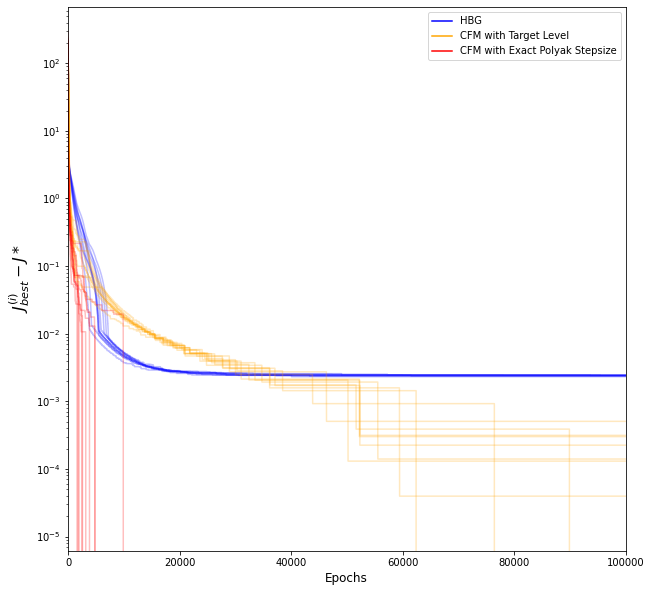

In [28]:
colors = ["blue", "orange", "red"]

for opt_name, color in zip(
    ["HBG", "CFM-TL", "CFM-BL"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        tl = list(np.array(tl) - best_loss)
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["HBG", "CFM with Target Level", "CFM with Exact Polyak Stepsize"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)} - J*$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 100000))
plt.yscale("log")
plt.show()

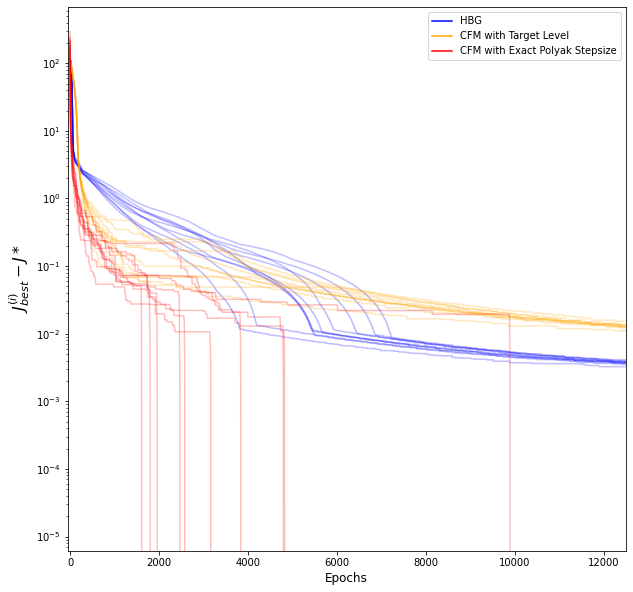

In [29]:
colors = ["blue", "orange", "red"]

for opt_name, color in zip(
    ["HBG", "CFM-TL", "CFM-BL"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        tl = list(np.array(tl) - best_loss)
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["HBG", "CFM with Target Level", "CFM with Exact Polyak Stepsize"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)} - J*$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 12500))
plt.yscale("log")
plt.show()

## Experiment 1.1 - One Hidden Layer with Sigmoid

In [30]:
n_experiment = "1.1"
experiment_folder = f"results/{n_experiment}"
if not os.path.exists(experiment_folder):
    os.mkdir(experiment_folder)

In [31]:
experiment_parameters = {"architecture": [10, 75, 2], "activation": "sigm", "l1": 1e-2}
model = MLP(experiment_parameters["architecture"], activation = experiment_parameters["activation"])
model.compile(error_function = MSE(), regularization_function = Lasso(l1 = experiment_parameters["l1"]))

### HBG

#### Grid Search

In [ ]:
alpha_values = [5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.75e-3, 1e-2, 2.5e-2, 5e-2]
beta_values = [0.1, 0.25, 0.5, 0.75, 0.9]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [HBG(alpha = a, beta = b) for a, b in product(alpha_values, beta_values)],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid)

joblib.dump(grid_search, f"{experiment_folder}/HBG_grid_search")

In [32]:
best_params_combinations = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: HBG Optimizer(alpha = 0.025, beta = 0.9)
-> Score: 1.188
Params combination N. 1
-> Optimizer: HBG Optimizer(alpha = 0.05, beta = 0.9)
-> Score: 1.19
Params combination N. 2
-> Optimizer: HBG Optimizer(alpha = 0.05, beta = 0.75)
-> Score: 1.236


#### Timing

In [21]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 8.221ms +- 0.123ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/HBG_random_runs")

In [33]:
train_losses = joblib.load(f"{experiment_folder}/HBG_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 1.21 +- 0.02


### CFM

#### Grid Search

In [ ]:
gamma_values = [0.5, 0.75, 1, 1.25, 1.5, 1.75]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 500, tolerance = 1e-4)
grid = {
    "optimizer": [CFM(gamma = g, delta_k = "100/(100 + k)") for g in gamma_values],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid, n_random_runs = 5)

joblib.dump(grid_search, f"{experiment_folder}/CFM_grid_search")

In [34]:
best_params_combinations = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3), "+-", round(best_params_combination["score_std"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.75)
-> Score: 1.2 +- 0.002
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 1.25)
-> Score: 1.233 +- 0.019
Params combination N. 2
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 1.75)
-> Score: 1.245 +- 0.007


#### Timing

In [22]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 8.975ms +- 0.187ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/CFM_random_runs")

In [35]:
train_losses = joblib.load(f"{experiment_folder}/CFM_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 1.407 +- 0.661


### Results

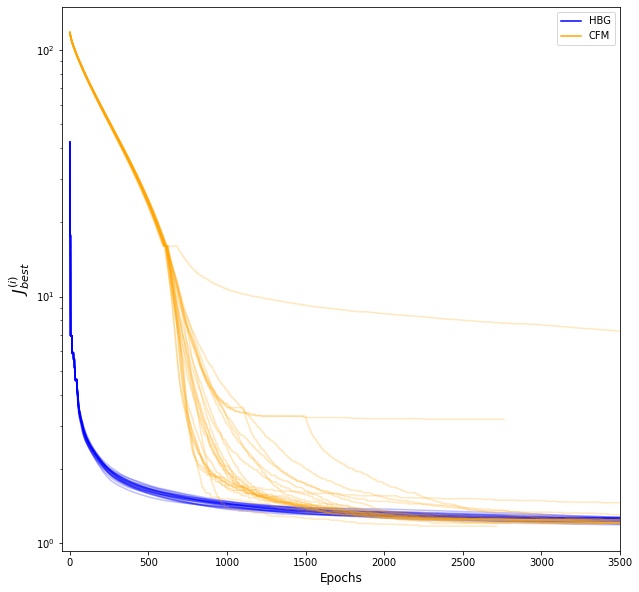

In [36]:
colors = ["blue", "orange"]

for opt_name, color in zip(
    ["HBG", "CFM"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["HBG", "CFM"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 3500))
plt.yscale("log")
plt.show()

## Experiment 1.2 - One Hidden Layer with ReLU

In [37]:
experiment_name = "1.2"
experiment_folder = f"results/{experiment_name}"
if not os.path.exists(experiment_folder):
    os.mkdir(experiment_folder)

In [38]:
experiment_parameters = {"architecture": [10, 75, 2], "activation": "relu", "l1": 1e-2}
model = MLP(experiment_parameters["architecture"], activation = experiment_parameters["activation"])
model.compile(error_function = MSE(), regularization_function = Lasso(l1 = experiment_parameters["l1"]))

### HBG

#### Grid Search

In [ ]:
alpha_values = [5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.75e-3, 1e-2, 2.5e-2, 5e-2]
beta_values = [0.1, 0.25, 0.5, 0.75, 0.9]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [HBG(alpha = a, beta = b) for a, b in product(alpha_values, beta_values)],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid)

joblib.dump(grid_search, f"{experiment_folder}/HBG_grid_search")

In [39]:
best_params_combinations = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: HBG Optimizer(alpha = 0.025, beta = 0.9)
-> Score: 0.864
Params combination N. 1
-> Optimizer: HBG Optimizer(alpha = 0.05, beta = 0.5)
-> Score: 0.866
Params combination N. 2
-> Optimizer: HBG Optimizer(alpha = 0.05, beta = 0.75)
-> Score: 0.867


#### Timing

In [25]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 3.476ms +- 0.153ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/HBG_random_runs")

In [40]:
train_losses = joblib.load(f"{experiment_folder}/HBG_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 0.878 +- 0.016


### CFM

#### Grid Search

In [ ]:
gamma_values = [0.5, 0.75, 1, 1.25, 1.5, 1.75]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 500, tolerance = 1e-4)
grid = {
    "optimizer": [CFM(gamma = g, delta_k = "100/(100 + k)") for g in gamma_values],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid, n_random_runs = 5)

joblib.dump(grid_search, f"{experiment_folder}/CFM_grid_search")

In [41]:
best_params_combinations = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3), "+-", round(best_params_combination["score_std"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.75)
-> Score: 0.889 +- 0.018
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 1)
-> Score: 0.894 +- 0.016
Params combination N. 2
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.5)
-> Score: 0.898 +- 0.023


#### Timing

In [26]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 3.408ms +- 0.094ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/CFM_random_runs")

In [42]:
train_losses = joblib.load(f"{experiment_folder}/CFM_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 0.895 +- 0.02


### Results

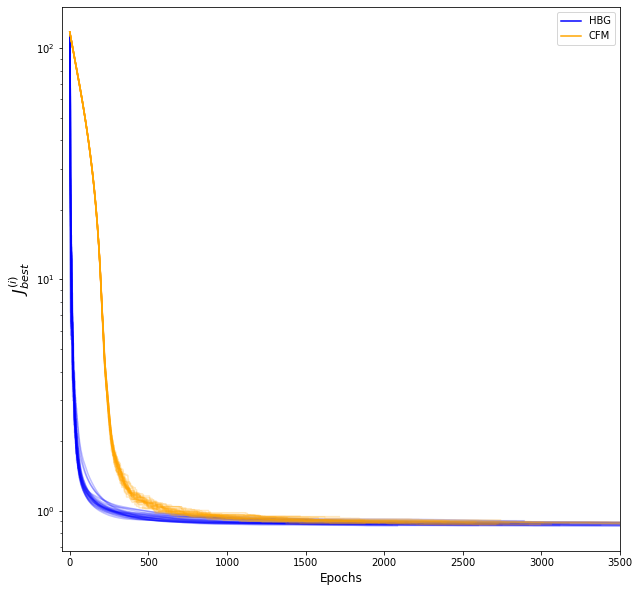

In [43]:
colors = ["blue", "orange"]

for opt_name, color in zip(
    ["HBG", "CFM"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["HBG", "CFM"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 3500))
plt.yscale("log")
plt.show()

## Experiment 2.1 - Two Hidden Layers with Sigmoid

In [44]:
experiment_name = "2.1"
experiment_folder = f"results/{experiment_name}"
if not os.path.exists(experiment_folder):
    os.mkdir(experiment_folder)

In [45]:
experiment_parameters = {"architecture": [10, 60, 30, 2], "activation": "sigm", "l1": 1e-2}
model = MLP(experiment_parameters["architecture"], activation = experiment_parameters["activation"])
model.compile(error_function = MSE(), regularization_function = Lasso(l1 = experiment_parameters["l1"]))

#### HBG

#### Grid Search

In [ ]:
alpha_values = [5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.75e-3, 1e-2, 2.5e-2, 5e-2]
beta_values = [0.1, 0.25, 0.5, 0.75, 0.9]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [HBG(alpha = a, beta = b) for a, b in product(alpha_values, beta_values)],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid)

joblib.dump(grid_search, f"{experiment_folder}/HBG_grid_search")

In [5]:
best_params_combinations = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: HBG Optimizer(alpha = 0.05, beta = 0.9)
-> Score: 1.401
Params combination N. 1
-> Optimizer: HBG Optimizer(alpha = 0.05, beta = 0.75)
-> Score: 1.407
Params combination N. 2
-> Optimizer: HBG Optimizer(alpha = 0.025, beta = 0.9)
-> Score: 1.444


#### Timing

In [29]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 10.864ms +- 0.554ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/HBG_random_runs")

In [6]:
train_losses = joblib.load(f"{experiment_folder}/HBG_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 1.353 +- 0.045


### CFM

In [52]:
a_values = [75, 150, 225]

#### Grid Search

In [ ]:
for a in a_values:
    gamma_values = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 1.9]
    early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
    grid = {
        "optimizer": [CFM(gamma = g, delta_k = f"{a}/({a} + k)") for g, a in product(gamma_values, a_values)],
        "epochs": [10000],
        "early_stopping": [early_stopping],
        "verbose": [False]
    }

    grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
    grid_search.fit(X, y, grid, n_random_runs = 5)

    joblib.dump(grid_search, f"{experiment_folder}/CFM-{a}_grid_search")

In [14]:
for a in a_values:
    best_params_combinations = joblib.load(f"{experiment_folder}/CFM-{a}_grid_search")._best_params_combinations
    print(f"*** Grid Search Results (a = {a}) ***")
    for i, best_params_combination in enumerate(best_params_combinations):
        print(f"Params combination N. {i}")
        print("-> Optimizer:", best_params_combination["params"]["optimizer"])
        print("-> Score:", round(best_params_combination["score"], 3), "+-", round(best_params_combination["score_std"], 3))
    print()

*** Grid Search Results (a = 75) ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 75/(75 + k), gamma = 0.75)
-> Score: 4.982 +- 5.54
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 75/(75 + k), gamma = 0.5)
-> Score: 6.503 +- 4.834
Params combination N. 2
-> Optimizer: CFM Optimizer(delta_k = 75/(75 + k), gamma = 1.75)
-> Score: 7.082 +- 4.654

*** Grid Search Results (a = 150) ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 150/(150 + k), gamma = 0.75)
-> Score: 5.276 +- 5.54
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 150/(150 + k), gamma = 1.9)
-> Score: 5.817 +- 3.622
Params combination N. 2
-> Optimizer: CFM Optimizer(delta_k = 150/(150 + k), gamma = 1.5)
-> Score: 7.084 +- 4.911

*** Grid Search Results (a = 225) ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 225/(225 + k), gamma = 1.75)
-> Score: 7.1 +- 4.027
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 225/(225 + k), gamma = 1

#### Timing

In [30]:
opt = CFM(delta_k = "150/(150 + k)", gamma = 0.75)
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 10.533ms +- 0.106ms


#### Random Runs

In [ ]:
for a in a_values:
    best_params = joblib.load(f"{experiment_folder}/CFM-{a}_grid_search")._best_params_combinations[0]["params"]

    n_random_runs = 25
    train_losses = []
    for run in range(1, n_random_runs + 1):
        model.fit(X, y, **best_params, random_seed = run)
        train_losses.append(model._eval["train_loss"])
        print(f"Run {run}/{n_random_runs} completed")

    joblib.dump(train_losses, f"{experiment_folder}/CFM-{a}_random_runs")

In [15]:
for a in a_values:
    train_losses = joblib.load(f"{experiment_folder}/CFM-{a}_random_runs")
    losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
    print(f"a = {a} -> Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

a = 75 -> Loss: 10.098 +- 8.144
a = 150 -> Loss: 11.502 +- 6.734
a = 225 -> Loss: 9.537 +- 8.293


### Results

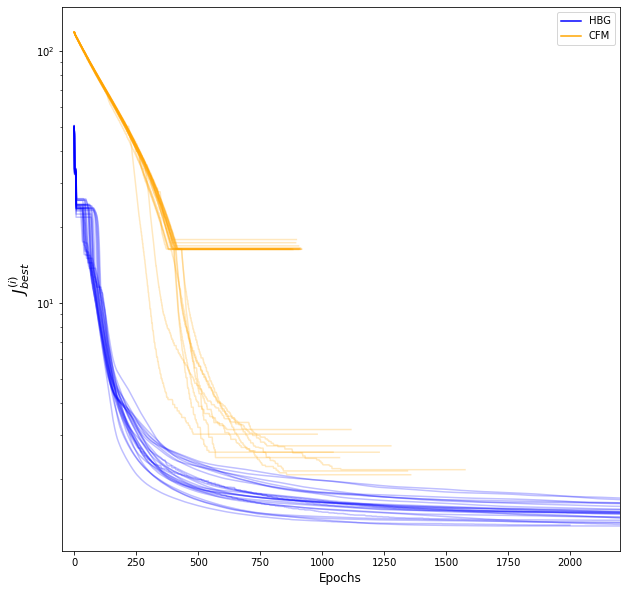

In [46]:
colors = ["blue", "orange"]

for opt_name, color in zip(
    ["HBG", "CFM-150"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["HBG", "CFM"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 2200))
plt.yscale("log")
plt.show()

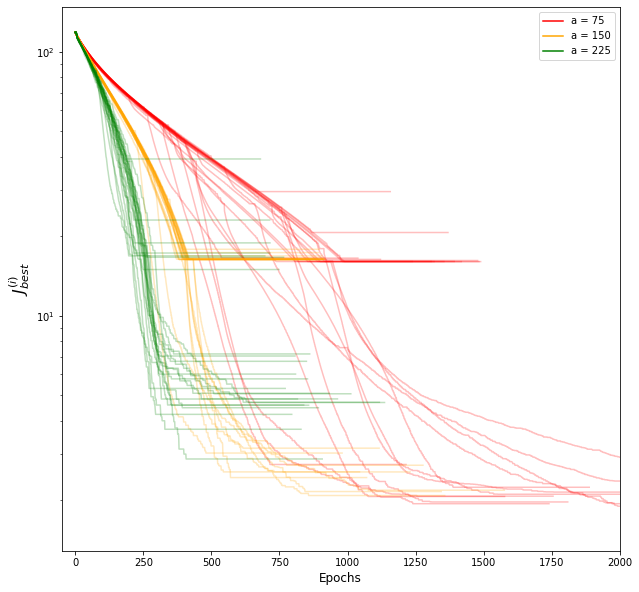

In [47]:
colors = ["red", "orange", "green"]

for opt_name, color in zip(
    ["CFM-75", "CFM-150", "CFM-225"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["a = 75", "a = 150", "a = 225"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 2000))
plt.yscale("log")
plt.show()

## Experiment 2.2 - Two Hidden Layers with ReLU

In [48]:
experiment_name = "2.2"
experiment_folder = f"results/{experiment_name}"
if not os.path.exists(experiment_folder):
    os.mkdir(experiment_folder)

In [49]:
experiment_parameters = {"architecture": [10, 60, 30, 2], "activation": "relu", "l1": 1e-2}
model = MLP(experiment_parameters["architecture"], activation = experiment_parameters["activation"])
model.compile(error_function = MSE(), regularization_function = Lasso(l1 = experiment_parameters["l1"]))

### HBG

#### Grid Search

In [ ]:
alpha_values = [5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.75e-3, 1e-2, 2.5e-2, 5e-2]
beta_values = [0.1, 0.25, 0.5, 0.75, 0.9]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [HBG(alpha = a, beta = b) for a, b in product(alpha_values, beta_values)],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid)

joblib.dump(grid_search, f"{experiment_folder}/HBG_grid_search")

In [45]:
best_params_combinations = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: HBG Optimizer(alpha = 0.00775, beta = 0.9)
-> Score: 0.816
Params combination N. 1
-> Optimizer: HBG Optimizer(alpha = 0.01, beta = 0.9)
-> Score: 0.818
Params combination N. 2
-> Optimizer: HBG Optimizer(alpha = 0.005, beta = 0.9)
-> Score: 0.83


#### Timing

In [33]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 4.853ms +- 0.066ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/HBG_random_runs")

In [46]:
train_losses = joblib.load(f"{experiment_folder}/HBG_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 0.816 +- 0.017


### CFM

In [ ]:
gamma_values = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1, 1.25, 1.5]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [CFM(gamma = g, delta_k = "100/(100 + k)") for g in gamma_values],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid, n_random_runs = 5)

joblib.dump(grid_search, f"{experiment_folder}/CFM_grid_search")

In [43]:
best_params_combinations = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3), "+-", round(best_params_combination["score_std"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.5)
-> Score: 0.915 +- 0.066
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.6)
-> Score: 1.005 +- 0.029
Params combination N. 2
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.15)
-> Score: 1.075 +- 0.062


#### Timing

In [34]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 5.131ms +- 0.07ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/CFM_random_runs")

In [44]:
train_losses = joblib.load(f"{experiment_folder}/CFM_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 0.942 +- 0.068


### CFM with Best Loss

#### Grid Search

In [ ]:
best_loss = 0.816

gamma_values = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1, 1.25, 1.5]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 500, tolerance = 1e-4)
grid = {
    "optimizer": [CFM(gamma = g, best_loss = best_loss) for g in gamma_values],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid, n_random_runs = 5)

joblib.dump(grid_search, f"{experiment_folder}/CFM-BL_grid_search")

In [47]:
best_params_combinations = joblib.load(f"{experiment_folder}/CFM-BL_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3), "+-", round(best_params_combination["score_std"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: CFM Optimizer(best_loss = 0.816, gamma = 0.2)
-> Score: 3.486 +- 2.572
Params combination N. 1
-> Optimizer: CFM Optimizer(best_loss = 0.816, gamma = 0.15)
-> Score: 4.284 +- 2.987
Params combination N. 2
-> Optimizer: CFM Optimizer(best_loss = 0.816, gamma = 0.1)
-> Score: 4.523 +- 2.207


#### Timing

In [35]:
best_params = joblib.load(f"{experiment_folder}/CFM-BL_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 4.991ms +- 0.084ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/CFM-BL_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 10
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/CFM-BL_random_runs")

In [48]:
train_losses = joblib.load(f"{experiment_folder}/CFM-BL_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 3.762 +- 3.207


### Results

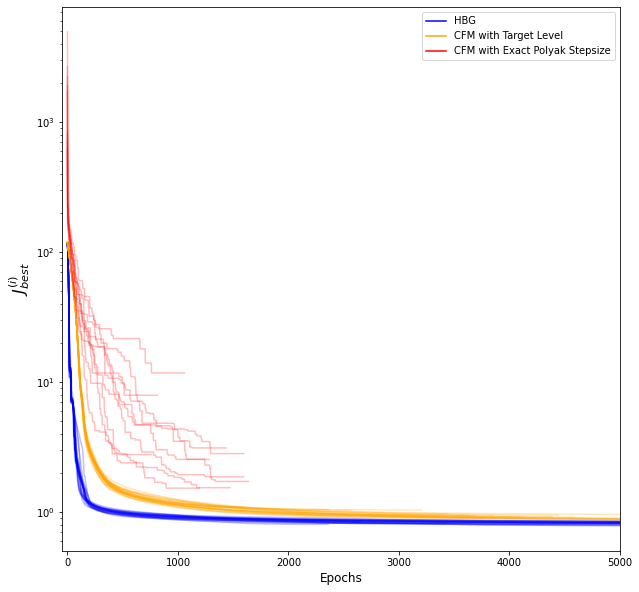

In [50]:
colors = ["blue", "orange", "red"]

for opt_name, color in zip(
    ["HBG", "CFM", "CFM-BL"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["HBG", "CFM with Target Level", "CFM with Exact Polyak Stepsize"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 5000))
plt.yscale("log")
plt.show()

## Experiment 3 - Three Hidden Layers with ReLU

In [51]:
experiment_name = "3"
experiment_folder = f"results/{experiment_name}"
if not os.path.exists(experiment_folder):
    os.mkdir(experiment_folder)

In [52]:
experiment_parameters = {"architecture": [10, 60, 45, 30, 2], "activation": "relu", "l1": 1e-1}
model = MLP(experiment_parameters["architecture"], activation = experiment_parameters["activation"])
model.compile(error_function = MSE(), regularization_function = Lasso(l1 = experiment_parameters["l1"]))

### HBG

#### Grid Search

In [ ]:
alpha_values = [5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.75e-3, 1e-2, 2.5e-2, 5e-2]
beta_values = [0.1, 0.25, 0.5, 0.75, 0.9]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [HBG(alpha = a, beta = b) for a, b in product(alpha_values, beta_values)],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid)

joblib.dump(grid_search, f"{experiment_folder}/HBG_grid_search")

In [66]:
best_params_combinations = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: HBG Optimizer(alpha = 0.001, beta = 0.9)
-> Score: 15.867
Params combination N. 1
-> Optimizer: HBG Optimizer(alpha = 0.0025, beta = 0.9)
-> Score: 15.882
Params combination N. 2
-> Optimizer: HBG Optimizer(alpha = 0.00075, beta = 0.9)
-> Score: 15.887


#### Timing

In [38]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 7.781ms +- 0.283ms


### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/HBG_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/HBG_random_runs")

In [61]:
train_losses = joblib.load(f"{experiment_folder}/HBG_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 15.881 +- 0.01


### CFM

#### Grid Search

In [ ]:
gamma_values = [0.3, 0.4, 0.5, 0.6, 0.75, 1, 1.25]
early_stopping = EarlyStopping(metric = "loss", target_dataset = "train", patience = 150, tolerance = 1e-4)
grid = {
    "optimizer": [CFM(gamma = g, delta_k = "100/(100 + k)") for g in gamma_values],
    "epochs": [10000],
    "early_stopping": [early_stopping],
    "verbose": [False]
}

grid_search = GridSearch(model, n_best_params_combinations = 3, metric = "loss", target_dataset = "train")
grid_search.fit(X, y, grid, n_random_runs = 5)

joblib.dump(grid_search, f"{experiment_folder}/CFM_grid_search")

In [65]:
best_params_combinations = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations
print("*** Grid Search Results ***")
for i, best_params_combination in enumerate(best_params_combinations):
    print(f"Params combination N. {i}")
    print("-> Optimizer:", best_params_combination["params"]["optimizer"])
    print("-> Score:", round(best_params_combination["score"], 3), "+-", round(best_params_combination["score_std"], 3))

*** Grid Search Results ***
Params combination N. 0
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.6)
-> Score: 4.815 +- 0.739
Params combination N. 1
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.4)
-> Score: 4.959 +- 2.666
Params combination N. 2
-> Optimizer: CFM Optimizer(delta_k = 100/(100 + k), gamma = 0.3)
-> Score: 6.139 +- 5.424


#### Timing

In [39]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]
opt = best_params["optimizer"]
n_epochs = 100
average_epoch_times = []
n_random_runs = 10
for run in range(n_random_runs):
    start = time()
    model.fit(X, y, optimizer = opt, epochs = n_epochs, random_seed = run, verbose = False)
    end = time()
    average_epoch_times.append((end - start) / n_epochs)
print(f"Time per epoch: {round(np.mean(average_epoch_times) * 1e3, 3)}ms +- {round(np.std(average_epoch_times) * 1e3, 3)}ms")

Time per epoch: 7.99ms +- 0.079ms


#### Random Runs

In [ ]:
best_params = joblib.load(f"{experiment_folder}/CFM_grid_search")._best_params_combinations[0]["params"]

n_random_runs = 25
train_losses = []
for run in range(1, n_random_runs + 1):
    model.fit(X, y, **best_params, random_seed = run)
    train_losses.append(model._eval["train_loss"])
    print(f"Run {run}/{n_random_runs} completed")

joblib.dump(train_losses, f"{experiment_folder}/CFM_random_runs")

In [59]:
train_losses = joblib.load(f"{experiment_folder}/CFM_random_runs")
losses = [compute_best_loss_k(tl)[-1] for tl in train_losses]
print("Loss:", round(np.mean(losses), 3), "+-", round(np.std(losses), 3))

Loss: 5.549 +- 2.414


### Results

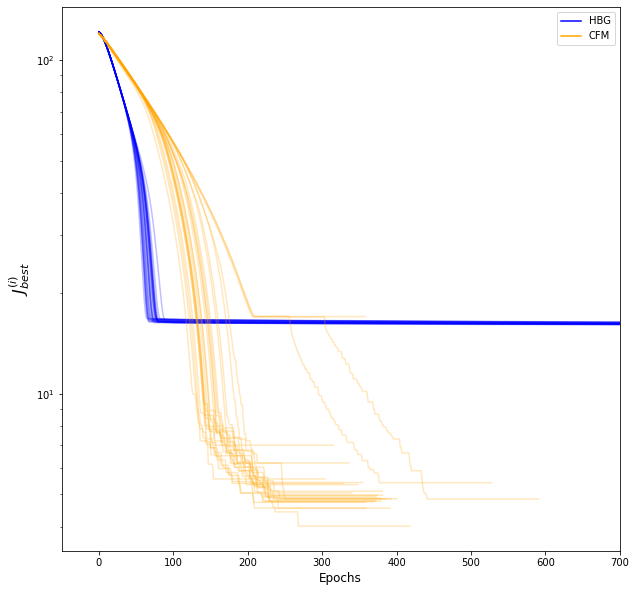

In [53]:
colors = ["blue", "orange"]

for opt_name, color in zip(
    ["HBG", "CFM"],
    colors
):
    
    train_losses = joblib.load(f"{experiment_folder}/{opt_name}_random_runs")

    train_best_losses = []
    for tl in train_losses:
        train_best_losses.append(compute_best_loss_k(tl))

    for tbl in train_best_losses:
        plt.plot(tbl, c = color, alpha = 0.25)

handles = [mlines.Line2D([], [], color = color) for color in colors]
labels = ["HBG", "CFM"]
plt.legend(handles = handles, labels = labels, loc = "upper right")
plt.ylabel(r"$J_{best}^{(i)}$", fontsize = 16)
plt.xlabel("Epochs", fontsize = 12)
plt.xlim((-50, 700))
plt.yscale("log")
plt.show()